In [46]:
import sys
from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, random

from IPython.display import display

#from sklearn.decomposition import PCA
import sklearn.linear_model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.python.keras.utils.vis_utils import plot_model

print(tf.version.VERSION)


2.9.1


In [47]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [48]:
#%tensorboard --logdir logs/fit

# Helper functions

In [49]:
def rebin(s, bins, wavelength_col = "w", value_col = "a", handle_nan = False):
    s['w_bins'] = pd.cut(s[wavelength_col], bins) # Cut the wavelength into bins
    s_bin = s.groupby(['w_bins'])[value_col].mean().reset_index() # Group by bin and average in the bin
    s = np.array(s_bin[value_col])
    if handle_nan:
        found = np.isnan(s)
        if found.any():
            s = [0 if found[i] else s[i] for i in range(len(s))]
        s = np.array(s)
    return s

def generate_bins(nr_bins):
    # Rebin the opacities
    bins = np.linspace(5.,35., num=nr_bins)#121)#[0, 5,10,15,20,25,30,35,40]
    new_wavelength = []
    for i in range(len(bins)):
        if i < len(bins)-1: 
            new_wavelength.append(bins[i]+(bins[i+1]-bins[i])/2)
    new_wavelength = np.array(new_wavelength)

    return bins, new_wavelength

def get_opacs(nr_bins=150):
    # Read in the opacities
    directory = "opacities"
    file_forsterite = 'Forsterite0.1.Kabs'
    opac_fo = np.loadtxt(os.path.join(directory, file_forsterite))
    file_amorphSilicate = 'AmorphousOlivineX0.5_0.1.Kabs'
    opac_am = np.loadtxt(os.path.join(directory, file_amorphSilicate))
    file_enstatite = 'Enstatite0.1.Kabs'
    opac_en = np.loadtxt(os.path.join(directory, file_enstatite))

    bins, new_wavelength = generate_bins(nr_bins)

    res = new_wavelength[1:-1] - new_wavelength[0:-2]
    opac_fo_df = pd.DataFrame(opac_fo, columns=['w', 'a'])
    opac_am_df = pd.DataFrame(opac_am, columns=['w', 'a'])
    opac_en_df = pd.DataFrame(opac_en, columns=['w', 'a'])

    opac_fo_bin = rebin(opac_fo_df, bins)
    opac_en_bin = rebin(opac_en_df, bins)
    opac_am_bin = rebin(opac_am_df, bins)

    return new_wavelength, [opac_fo_bin, opac_en_bin, opac_am_bin]

def calc_spectra(a_fo, a_en, a_am, T, nr_bins=150, opacs=[]):

    def B(lambd, T, micron=True):
        c = 299792458 # metres per second.
        h = 6.62607015e-34 # joule second
        k = 1.380649e-23 # joule per kelvin (K)

        if micron:
            lambd = lambd*1e-6
        return (2*h*c**2/lambd**5) * 1 / (np.exp(h*c/(k*T*lambd))-1)

    def syn_spec(w, a, opac, T):
        spec = np.zeros(opac[0].shape)
        for i in range(len(a)):
            spec = spec + a[i]*opac[i]
        f = B(w, T) * spec
        f = f/f.max()
        return f
    
    if len(opacs) == 0:
        w, opacs = get_opacs(nr_bins)
    else:
        w, opacs = opacs

    return w, syn_spec(w, (a_fo, a_en, a_am), opacs, T)

def generate_opticallythin_spectra(nr, nr_bins=150, \
        cr_a_min = 0, cr_a_max = 8, \
        T_min = 100, T_max = 300, \
        norm = True):

    # Generate parameters of the radiative model

    a_fo = np.array([random.uniform(cr_a_min,cr_a_max) for i in range(nr)])
    a_en = np.array([random.uniform(cr_a_min,cr_a_max) for i in range(nr)])
    a_am = [100-(a_fo[i]+a_en[i]) for i in range(nr)]
    Ts = np.array([random.uniform(T_min,T_max) for i in range(nr)])
    
    w, opacs = get_opacs(nr_bins=150)


    specs = np.array([calc_spectra(a_fo[i], a_en[i], a_am[i], Ts[i], nr_bins, [w,opacs])[1] for i in range(len(a_fo))])
    
    if norm:
        a_fo = a_fo/max(a_fo)#cr_a_max
        a_en = a_en/max(a_en)#cr_a_max
        Ts = Ts/max(Ts)#T_max

    grid = np.array([a_fo, a_en, Ts]).T
    
    return specs, grid

# From spectrum to parameters

### The data

In [50]:
def get_data(nr_train = 10000):
    nr_test = int(0.2* nr_train)
    X_train, train_grid = generate_opticallythin_spectra(nr_train, T_min = 50, T_max = 500)
    X_test, test_grid = generate_opticallythin_spectra(nr_test, T_min = 50, T_max = 500)

    return X_train, train_grid, X_test, test_grid

# SHUFFLE??
#df = df.iloc[np.random.permutation(len(df))]

## Fit all params with one output

In [51]:
def run_one_outputs(X_train, Y_train, X_test, Y_test, neurons = 128,\
                           learning_rate=0.005, epochs = 100, verbose=0, save_to=""):

    def make_NN_model(input_shape):
        input_data = tf.keras.Input(shape=input_shape)
        D1 = tf.keras.layers.Dense(units= neurons, activation='relu')(input_data)
    
        output = tf.keras.layers.Dense(units= 3, name='output')(D1)
        model = tf.keras.Model(inputs=input_data, outputs=output)
        return model

    NN_model = make_NN_model((X_train.shape[1],))
    print(NN_model.summary())
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    metrics={'output': tf.keras.metrics.RootMeanSquaredError()}
    loss = {'output': 'mse'}

    NN_model.compile(optimizer=opt,
                     loss=loss,
                     metrics=metrics)

    history = NN_model.fit(X_train, Y_train, epochs=epochs, \
                                batch_size=10,\
                                validation_data=(X_test, Y_test), verbose=verbose,\
                                #callbacks=[cp_callback]\
                                )
    if (save_to != ""):
        NN_model.save(save_to)


    
    return history, NN_model

In [56]:
hyperp, results, models = [], [], []
for p in [{'a': 0.01, 'n': 128, 'e':20, 'nr_train':10000},#000},
         ]:
    alpha = p['a']
    neurons = p['n']
    epochs = p['e']
    nr_train = p['nr_train']
    
    X_train, Y_train, X_test, Y_test = get_data(nr_train)

    checkpoint_path = "NN_synthspectra_simple_final_models/spec-to-param/model"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    try:
        model = tf.keras.models.load_model(checkpoint_path)
        print("Model read from disk")
        model.summary()
        loss, acc = model.evaluate(X_train, Y_train, verbose=2)
    except:
        print("No model found")

        history, model = run_one_outputs(
            X_train, Y_train, X_test, Y_test,
            neurons = neurons, learning_rate=alpha, 
            epochs = epochs, verbose=1, save_to = checkpoint_path)
        
        plt.plot(history.history['loss'])
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
        plt.close()
    hyperp.append([alpha, neurons, epochs,nr_train])
    models.append(model)
#     results.append([history.history['loss'][-1], 
#                         history, model.predict(X_test),
#                         model, Y_test])
    #print('nr_train: ', nr_train, 'neurons: ', neurons, 'alpha: ', alpha, 'epochs: ', epochs, 'loss: ', history.history['loss'][-1])

Model read from disk
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 149)]             0         
                                                                 
 dense_13 (Dense)            (None, 128)               19200     
                                                                 
 output (Dense)              (None, 3)                 387       
                                                                 
Total params: 19,587
Trainable params: 19,587
Non-trainable params: 0
_________________________________________________________________
313/313 - 0s - loss: 9.7898e-04 - root_mean_squared_error: 0.0313 - 425ms/epoch - 1ms/step


32/32 [==============================] - 0s 1ms/step


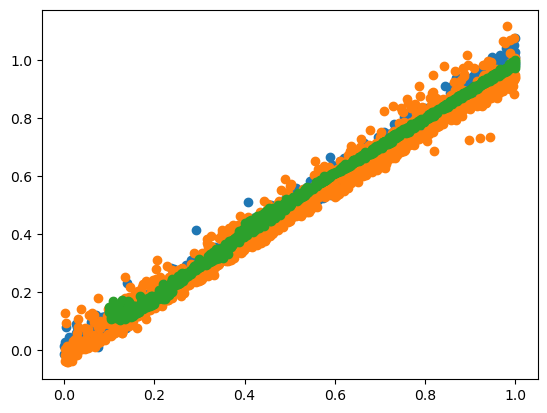

In [55]:
X_train, Y_train, X_test, Y_test = get_data(1000)
for i in range(3):
    Y_pred = list(zip(*models[0].predict(X_train)))[i]
    plt.scatter( list(zip(*Y_train))[i], Y_pred)

# Junk

## Model

In [4]:
def run_deepNN_two_outputs(X_train, Y_train, X_test, Y_test, neurons = 128,\
                           learning_rate=0.005, epochs = 100, verbose=0):

    def make_NN_model(input_shape):
        input_data = tf.keras.Input(shape=input_shape)
        D_fo1 = tf.keras.layers.Dense(units= neurons, activation='relu')(input_data)
        
        D_T1 = tf.keras.layers.Dense(units= neurons, activation='relu')(input_data)

        output_fo = tf.keras.layers.Dense(units= 1, name='output_fo')(D_fo1)
        output_T = tf.keras.layers.Dense(units= 1, name='output_T')(D_T1)
        model = tf.keras.Model(inputs=input_data, outputs=[output_fo, output_T])
        return model

    NN_model = make_NN_model((X_train.shape[1],))

    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    #opt = tf.keras.optimizers.SGD(lr=learning_rate)
    metrics={'output_fo': tf.keras.metrics.RootMeanSquaredError(),\
            'output_T': tf.keras.metrics.RootMeanSquaredError()}
    loss = {'output_fo': 'mse',#tf.keras.losses.MeanSquaredError(),\
           'output_T': 'mse'}#tf.keras.losses.MeanSquaredError()}

    
    NN_model.compile(optimizer=opt,
                     loss=loss,
                     metrics=metrics)


    
    history = NN_model.fit(X_train, Y_train, epochs=epochs, \
                           batch_size=10,\
                           validation_data=(X_test, Y_test), verbose=verbose)

    
    
    return history, NN_model

New resolution:  0.2013 +/- 0.0
149 150 pipo
Nan values:  False
New resolution:  0.2013 +/- 0.0
149 150 pipo
Nan values:  False
nr_train:  10000 neurons:  alpha:  0.005 epochs:  100 loss:  1.1639794237539172 output_fo_loss:  0.016762067 output_T_loss:  1.1472166


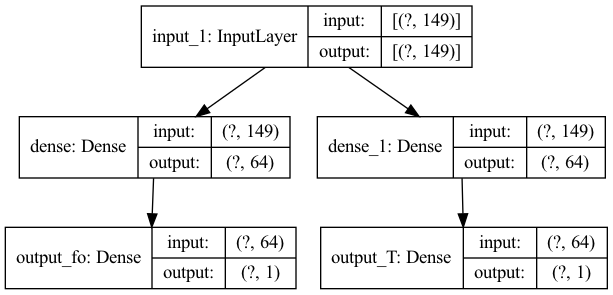

In [5]:
results = []
# Does not work: 
# - One layer does not work
# - Two layer do not wor

# Starts to work
# - Second layer for only forsterite starts to work

# Important: got it to work with the Adam optimizer, not the SGD
for p in [{'a': 0.005, 'n': 64, 'e':100, 'nr_train':10000},\
          #{'a': 0.001, 'n': 128, 'n2':64, 'n3':32, 'e':20, 'nr_train':10000},\
         ]:
    alpha = p['a']
    neurons = p['n']
    epochs = p['e']
    nr_train = p['nr_train']

    X_train, Y_train_fo, Y_train_T, X_test, Y_test_fo, Y_test_T = get_data(nr_train)
    Y_train = (Y_train_fo, Y_train_T)
    Y_test = (Y_test_fo, Y_test_T)
    
    history, model = run_deepNN_two_outputs(
        X_train, Y_train, X_test, Y_test,
        neurons = neurons, \
        learning_rate=alpha, 
        epochs = epochs, verbose=0)
    results.append([alpha, neurons, epochs,nr_train,
                    history.history['loss'][-1], 
                    history, model.predict(X_test),
                    model, Y_test])
    print('nr_train: ', nr_train, 'neurons: ', \
          'alpha: ', alpha, 'epochs: ', epochs, \
          'loss: ', history.history['loss'][-1],\
          'output_fo_loss: ', history.history['output_fo_loss'][-1],\
          'output_T_loss: ', history.history['output_T_loss'][-1],\
         )

    display(plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png'))
    


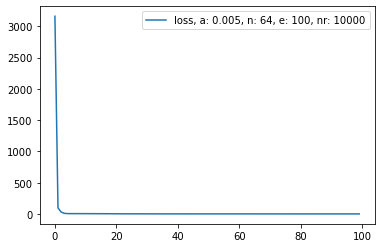

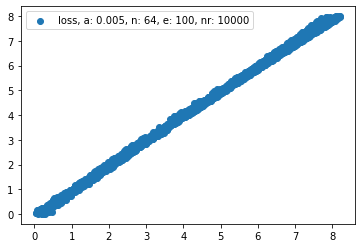

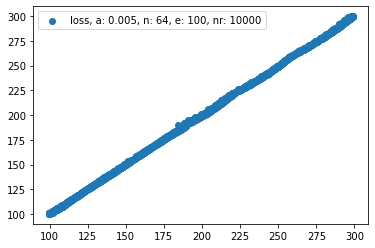

In [6]:
for i in range(len(results)):
    plt.plot(results[i][5].history['loss'], \
             label="loss"+\
             ", a: "+str(results[i][0])+\
             ", n: "+str(results[i][1])+\
             ", e: "+str(results[i][2])+\
             ", nr: "+str(results[i][3])
                )
plt.legend()
plt.show()

for i in range(len(results)):
    plt.scatter(results[i][6][0], results[i][8][0],\
             label="loss"+\
             ", a: "+str(results[i][0])+\
             ", n: "+str(results[i][1])+\
             ", e: "+str(results[i][2])+\
             ", nr: "+str(results[i][3])
                )
plt.legend()
plt.show()

for i in range(len(results)):
    plt.scatter(results[i][6][1], results[i][8][1],\
             label="loss"+\
             ", a: "+str(results[i][0])+\
             ", n: "+str(results[i][1])+\
             ", e: "+str(results[i][2])+\
             ", nr: "+str(results[i][3])
                )
plt.legend()
plt.show()

In [37]:
X_train.shape

(10000, 149)

new
Excluding:  TW-Hya.csv
Number of observed objects:  25


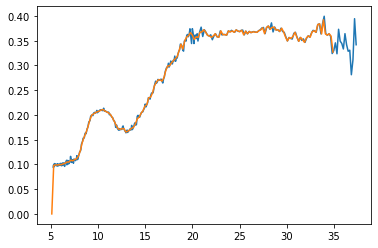

In [6]:
s.reshape(1,149).shape

(1, 149)

[array([[0.9953314]], dtype=float32), array([[402.0963]], dtype=float32)]